In [133]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Reshape, Flatten, RepeatVector
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model, Sequential
from keras import backend as K
from keras import objectives

import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
# use the sampled latent points to generate new latent points z in the latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(latent_dim,), 
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# custom loss function
def vae_loss(x, x_decoded_mean):
    
    # cross entropy term (reconstruction error)
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
#     xent_loss = original_dim * objectives.mean_squared_error(x, x_decoded_mean)
    
    # KL-divergence term (regularization term)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)  
    
    # sum both terms
    return xent_loss + kl_loss

# apply all layers in a list
def h_apply(h_l, x):
    y = x
    for h in h_l:
        y = h(y)
    return y

In [3]:
# G = nx.karate_club_graph()
# G = nx.read_gml("dolphins_labelled.gml")
G = nx.read_gml("embedded_karate.gml")
# G = nx.read_gml("embedded_football.gml")
# G = nx.read_gml("embedded_yeast_uetz.gml")
# G = nx.read_gpickle("embedded_yeast_union.gpickle")
# G = nx.read_gpickle("embedded_yeast_reactome.gpickle")
# G = nx.read_gpickle("hierarchical_benchmark.gpickle")
G = max(nx.connected_component_subgraphs(G), key=len)

In [154]:
N = nx.number_of_nodes(G)
E = nx.number_of_edges(G)

A = np.array(nx.adjacency_matrix(G).todense())
D = np.diag(A.sum(axis=1))

loop = 0.5

W = A.dot(np.diag(1./D.diagonal()))
W = loop * np.identity(N) + (1 - loop) * W

In [7]:
# 1 hot vector
P = np.append(np.ones(1), np.zeros(N - 1))

In [12]:
A.sum(axis=1, dtype=np.float32) / A.sum(axis=1).sum()

array([ 0.1025641 ,  0.05769231,  0.06410257,  0.03846154,  0.01923077,
        0.02564103,  0.02564103,  0.02564103,  0.03205128,  0.01282051,
        0.01923077,  0.00641026,  0.01282051,  0.03205128,  0.01282051,
        0.01282051,  0.01282051,  0.01282051,  0.01282051,  0.01923077,
        0.01282051,  0.01282051,  0.01282051,  0.03205128,  0.01923077,
        0.01923077,  0.01282051,  0.02564103,  0.01923077,  0.02564103,
        0.02564103,  0.03846154,  0.07692308,  0.10897436], dtype=float32)

In [155]:
W_ = np.linalg.matrix_power(W, 5)

In [156]:
n = 2

mu_1, mu_2 = -np.ones(n), np.ones(n)
sigma = np.ones(n)

scores = np.random.normal(size=(N, n),
          loc=[mu_1 if k=="Mr. Hi" else mu_2 for k in nx.get_node_attributes(G, "club").values()], scale=sigma)

In [157]:
scores = np.random.normal(size=(N, n))

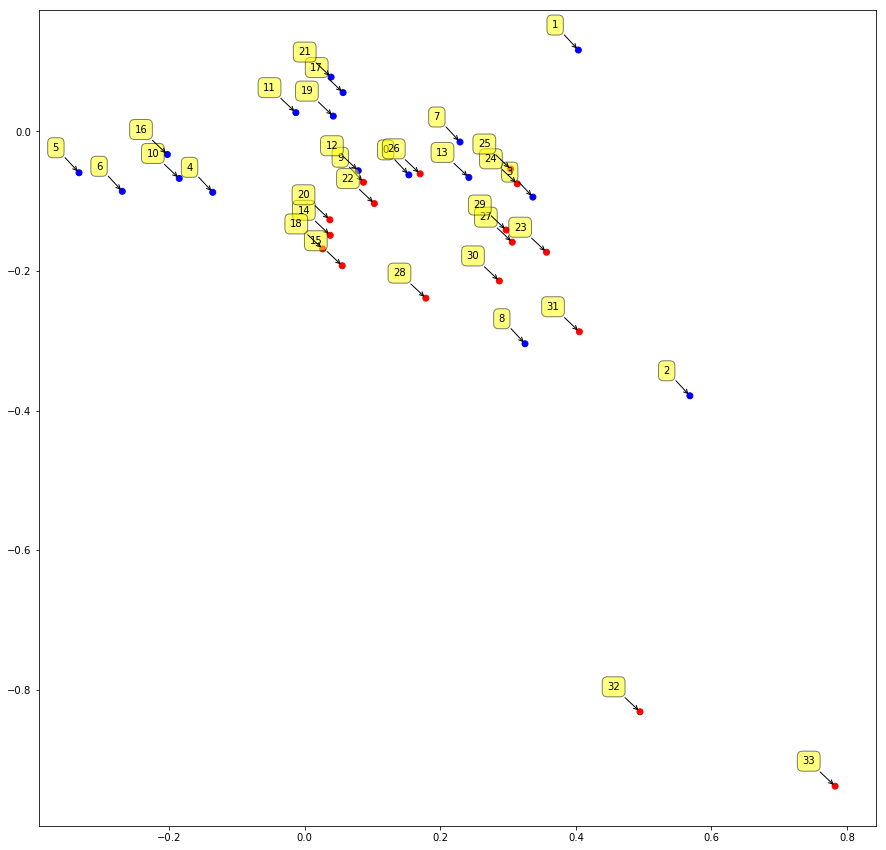

In [159]:
plt.figure(figsize=(15, 15))
for label, i, j in zip(G.nodes(), W_.dot(scores)[:,0], W_.dot(scores)[:, 1]):
    plt.annotate(
        label,
        xy=(i, j), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
plt.scatter(W_.dot(scores)[:,0], W_.dot(scores)[:,1], 
            c = ["b" if k == "Mr. Hi" else "r" for k in nx.get_node_attributes(G, "club").values()])

In [116]:
A.dot(scores)

array([[ -1.47018401e+01,  -1.17545691e+01,  -1.18754314e+01,
         -1.73769914e+01,  -1.45324838e+01,  -1.74883635e+01,
         -1.44508541e+01,  -8.97619284e+00,  -1.92389323e+01,
         -1.21339368e+01],
       [ -7.58090082e+00,  -7.34264327e+00,  -3.02296974e+00,
         -1.13109347e+01,  -5.30787529e+00,  -6.68222429e+00,
         -9.00418939e+00,  -4.21286164e+00,  -1.05331343e+01,
         -6.33305829e+00],
       [ -7.10737233e+00,  -3.22165725e+00,  -1.08103818e+00,
         -6.32768191e+00,  -1.45477598e+00,   2.16905414e+00,
         -2.94814389e+00,  -3.43266672e+00,  -1.13133509e+00,
         -2.03225371e+00],
       [ -4.89688933e+00,  -6.59574126e+00,  -5.92820884e+00,
         -9.76969675e+00,  -4.43328555e+00,  -4.21366314e+00,
         -6.47528779e+00,  -4.31325555e+00,  -8.49529048e+00,
         -2.27607019e+00],
       [ -2.30514599e+00,  -2.86167026e+00,  -2.03835835e+00,
         -2.86597604e+00,  -1.58888035e+00,  -1.96245053e+00,
         -3.51378568e+00

In [35]:
num_edges, original_dim = W_.shape
batch_size = 50
latent_dim = 2
intermediate_dims = [32]
epsilon_std = 1

In [81]:
x = Input(batch_shape=(batch_size, original_dim))

h = []
for i in range(len(intermediate_dims)):
    h.append(Dense(intermediate_dims[i], activation='relu'))

z_mean = Dense(latent_dim)(h_apply(h, x))
z_log_var = Dense(latent_dim)(h_apply(h, x))

In [82]:
# generate latent points (lambda function layer)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [83]:
h_decoded = []
for i in range(len(intermediate_dims)):
    h_decoded.append(Dense(intermediate_dims[-1-i], activation='relu'))

# output layer
h_decoded.append(Dense(original_dim, activation='relu'))

x_decoded_mean = h_apply(h_decoded, z)

In [84]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# compile VAE model
vae.compile(optimizer="rmsprop", loss=vae_loss)

In [89]:
# train model
vae.fit(W_, W_,
        shuffle=True,
        epochs=100000,
        batch_size=batch_size,
        validation_split=0, verbose=False)

In [90]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
W_encoded = encoder.predict(W_, batch_size=batch_size)

In [91]:
assignments = nx.get_node_attributes(G, "club").values()

c = []

for e1, e2 in G.edges():
    c1 = assignments[e1]
    c2 = assignments[e2]
    
    if c1 == c2:
        if c1 == "Mr. Hi":
            c.append("b")
        else:
            c.append("r")
    else:
        c.append("g")

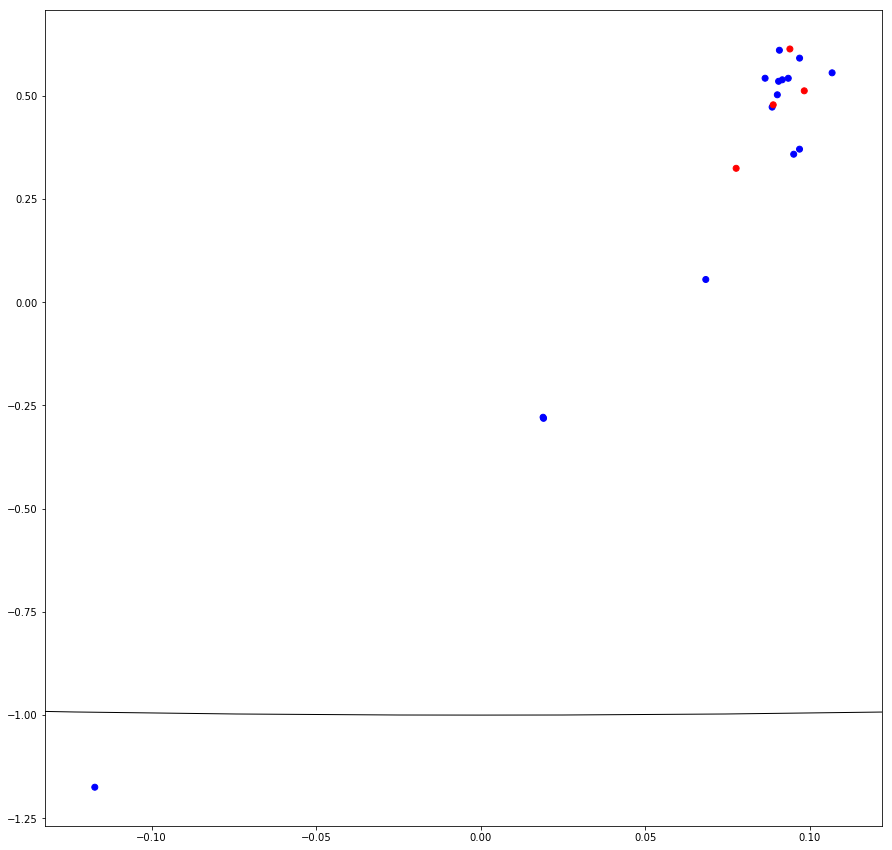

In [92]:
plt.figure(figsize=(15, 15))

# for label, i, j in zip(A.sum(axis=1), S_encoded[:, 0], S_encoded[:, 1]):
#     plt.annotate(
#         label,
#         xy=(i, j), xytext=(-20, 20),
#         textcoords='offset points', ha='right', va='bottom',
#         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
#         arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

# nodes = np.array(G.nodes())
# for n1, n2 in G.edges():
#     i, = np.where(nodes == n1)
#     j, = np.where(nodes == n2)
#     plt.plot(S_encoded[(i, j), 0], S_encoded[(i, j), 1], c="k", 
# #              linewidth = 3 * np.exp(- np.linalg.norm(S_encoded[i] - S_encoded[j]) ** 2 / (2 * 0.5 ** 2) ))
#              linewidth = 0.3)
    
plt.scatter(W_encoded[15:, 0], 
        W_encoded[15:, 1], 
            c = ["b" if v == "Mr. Hi" else "r" for v in nx.get_node_attributes(G, "club").values()],
#             c="k",
           )

c1 = plt.Circle((0,0), radius=1, fill=False)
c2 = plt.Circle((0,0), radius=2, fill=False)
c3 = plt.Circle((0,0), radius=3, fill=False)

ax = plt.gca()
ax.add_artist(c1)
ax.add_artist(c2)
ax.add_artist(c3)

In [21]:
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
# _h_decoded = decoder_h(decoder_input)
# _x_decoded_mean = decoder_mean(_h_decoded)
_x_decoded_mean = h_apply(h_decoded, decoder_input)
generator = Model(decoder_input, _x_decoded_mean)

In [24]:
E_decoded = generator.predict(E_encoded)
E_decoded[E_decoded < 1e-1] = 0

In [29]:
num_samples = 100000
# generate sample according to prior
z_samples = np.random.normal(loc=0, scale=1, size=(num_samples, latent_dim))
# print z_sample
generated_edges = generator.predict(z_samples)
# plt.imshow(generated_nodes, cmap="hot")
generated_edges[generated_edges < 1e-1] = 0

In [38]:
zip(assignments, generated_edges[15])

[(u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Officer', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Officer', 0.0),
 (u'Officer', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Officer', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Officer', 0.0),
 (u'Mr. Hi', 0.0),
 (u'Officer', 0.0),
 (u'Officer', 0.42956689),
 (u'Officer', 0.0),
 (u'Officer', 0.0),
 (u'Officer', 0.0),
 (u'Officer', 0.63944179),
 (u'Officer', 0.0),
 (u'Officer', 0.0),
 (u'Officer', 0.0),
 (u'Officer', 0.0),
 (u'Officer', 0.0),
 (u'Officer', 0.99911982)]

In [39]:
consensus = np.zeros((nx.number_of_nodes(G), nx.number_of_nodes(G)))

In [40]:
for edge in generated_edges:
    
    connected_nodes = np.where(edge > 0)[0]
    
    for n1 in connected_nodes:
        
        for n2 in connected_nodes[connected_nodes != n1]:
            
            consensus[n1, n2] += 1

consensus /= consensus.max()

In [41]:
zip(assignments, consensus[5], np.array(nx.adjacency_matrix(G).todense())[5])

[(u'Mr. Hi', 0.36745616032794354, 1),
 (u'Mr. Hi', 0.0, 0),
 (u'Mr. Hi', 0.0, 0),
 (u'Mr. Hi', 0.0, 0),
 (u'Mr. Hi', 0.37998178091550899, 0),
 (u'Mr. Hi', 0.0, 0),
 (u'Mr. Hi', 0.33739467091778635, 1),
 (u'Mr. Hi', 0.0, 0),
 (u'Mr. Hi', 0.0075153723525392853, 0),
 (u'Officer', 0.0, 0),
 (u'Mr. Hi', 0.25483944431792305, 1),
 (u'Mr. Hi', 0.020496470052379867, 0),
 (u'Mr. Hi', 0.0, 0),
 (u'Mr. Hi', 0.0, 0),
 (u'Officer', 0.0, 0),
 (u'Officer', 0.0, 0),
 (u'Mr. Hi', 0.14837166932361648, 1),
 (u'Mr. Hi', 0.0, 0),
 (u'Officer', 0.0, 0),
 (u'Mr. Hi', 0.0, 0),
 (u'Officer', 0.0, 0),
 (u'Mr. Hi', 0.08950125256205875, 0),
 (u'Officer', 0.0, 0),
 (u'Officer', 0.0, 0),
 (u'Officer', 0.058642678205420178, 0),
 (u'Officer', 0.042587109997722618, 0),
 (u'Officer', 0.0, 0),
 (u'Officer', 0.0, 0),
 (u'Officer', 0.0, 0),
 (u'Officer', 0.0, 0),
 (u'Officer', 0.0, 0),
 (u'Officer', 0.074356638578911408, 0),
 (u'Officer', 0.0, 0),
 (u'Officer', 0.0, 0)]